In [228]:
import numpy as np
import matplotlib.pyplot as plt
import torch
from BaseSMLM.generators import *
from DeepSMLM.models import Ring_Rad1_K5_SPAD
from SPICE.mcmc import run_langevin_dynamics

In [229]:
def show(adu,spikes,theta):
    nx,ny = adu.shape
    fig,ax=plt.subplots(1,3)
    ax[0].scatter(theta[1,:],theta[0,:],color='black',s=5)
    ax[0].set_aspect(1.0)
    ax[0].invert_yaxis()
    ax[0].set_xlim([0,nx]); ax[0].set_ylim([0,ny])
    ax[1].imshow(adu,cmap=plt.cm.BuGn_r)
    ax[2].imshow(spikes,cmap='gray')

### Generate some example SPAD data

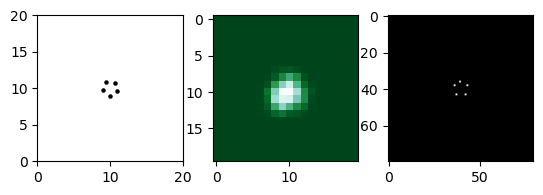

In [230]:
nx = ny = 20
radius = 1.0
nspots = 5
ring2d = Ring2D(nx,ny)
counts,spikes,theta_star = ring2d.forward(radius,nspots,N0=10,offset=0.0,var=0.0,nframes=100)
adu = np.sum(counts,axis=0)
show(adu,spikes[0],theta_star)

In [231]:
def sampleZ(bstar,M):
    """Rejection sampling for Z|M"""
    rows,cols = bstar.shape
    U = np.random.uniform(size=(rows,cols))
    Z = np.zeros_like(U)
    Z[U < bstar] = 1
    num_objects = np.sum(Z).astype(int)
    if num_objects > M:
        idx = np.argwhere(Z)
        x = np.arange(0,num_objects,1)
        to_remove = np.random.choice(x,size=num_objects-M,replace=False)
        ridx = idx[to_remove,:]
        Z[ridx[:, 0], ridx[:, 1]] = 0
    return Z

### Load a default DeepSTORM model, estimate of emitter locations

In [232]:
cnn_config = {'thresh_cnn':20,'radius':4,'pixel_size_lateral':108.3}
M = 5 #give M for now
model = Ring_Rad1_K5_SPAD(cnn_config)
adu = adu[np.newaxis,np.newaxis,:,:] #add batch and channel index for torch
spots,bstar = model.forward(adu)

Model forward on frame 0


### Extract $Z$ from CNN output

5.0


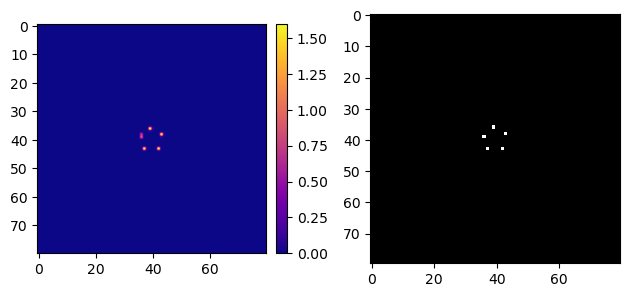

In [233]:
bstar = bstar / 500 #renormalize bstar for now
Z = sampleZ(bstar,M)
fig,ax=plt.subplots(1,2)
im = ax[0].imshow(bstar,cmap='plasma')
plt.colorbar(im,fraction=0.046, pad=0.04)
ax[1].imshow(Z,cmap='gray')
plt.tight_layout()
print(np.sum(Z))

### Run Langevin dynamics

In [234]:
theta = np.zeros((2,M))
z = 0.25*np.argwhere(Z > 0).T
#z[[0,1],:] = z[[1,0],:]
theta[:2,:] = z
theta_ = np.ones_like(theta)
theta_[:,0] *= 0.92; theta[:,1] *= 1000
theta_init = np.concatenate([theta,theta_],axis=0) #initialize sigma and N0

adu = np.squeeze(adu)
lr = torch.tensor(np.array([1e-9,1e-9,0.0,0.0])) #only update x,y
theta,loglikes = run_langevin_dynamics(adu,initial_params=theta_init,lr=lr,
                                       num_samples=1000,warmup_steps=100,print_every=100)
print(f'Average log likelihood: {np.mean(loglikes)}')

MCMC step 0
MCMC step 100
MCMC step 200
MCMC step 300
MCMC step 400
MCMC step 500
MCMC step 600
MCMC step 700
MCMC step 800
MCMC step 900
MCMC step 1000
Average log likelihood: 1311.2972353445068


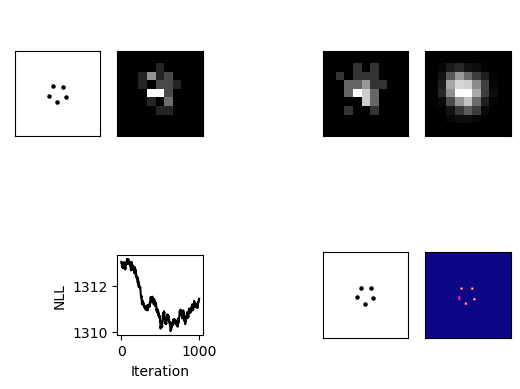

In [245]:
fig,ax=plt.subplots(2,5)
min,max = 5,15
ax[0,0].scatter(theta_star[1,:],theta_star[0,:],color='black',s=5)
ax[0,0].set_xticks([]); ax[0,0].set_yticks([])
ax[0,0].set_xlim([min,max]); ax[0,0].set_ylim([min,max])
ax[0,0].set_aspect('equal')
ax[0,2].set_axis_off(); ax[1,2].set_axis_off()
ax[0,1].imshow(counts[0],cmap='gray')
ax[0,1].set_xlim([min,max]); ax[0,1].set_ylim([min,max])
ax[0,1].set_xticks([]); ax[0,3].set_xticks([])
ax[0,1].set_yticks([]); ax[0,3].set_yticks([])
ax[0,3].imshow(counts[-1],cmap='gray')
ax[0,3].set_xlim([min,max]); ax[0,3].set_ylim([min,max])
ax[0,4].imshow(np.squeeze(adu),cmap='gray')
ax[0,4].set_xticks([]); ax[0,4].set_yticks([])
ax[0,4].set_xlim([min,max]); ax[0,4].set_ylim([min,max])
ax[1,4].imshow(bstar,cmap='plasma')
ax[1,4].set_xticks([]); ax[1,4].set_yticks([])
ax[1,4].set_xlim([4*min,4*max]); ax[1,4].set_ylim([4*min,4*max])
ax[1,0].set_axis_off()
ax[1,3].scatter(theta_star[1,:],theta_star[0,:],color='black',s=5)
ax[1,3].set_xticks([]); ax[1,3].set_yticks([])
ax[1,3].set_xlim([min,max]); ax[1,3].set_ylim([min,max])
ax[1,3].set_aspect('equal')
#for ax_ in ax.ravel():
#    ax_.set_aspect('equal')
ax[1,1].plot(loglikes,color='black')
ax[1,1].set_xlabel('Iteration')
ax[1,1].set_ylabel('NLL')
ax[1,1].set_aspect(300.0)

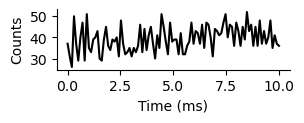

In [259]:
fig,ax=plt.subplots(figsize=(3,2))
time = np.linspace(0,10,100)
ax.plot(time,np.sum(counts,axis=(1,2)),color='black')
ax.spines[['right', 'top']].set_visible(False)
ax.set_xlabel('Time (ms)')
ax.set_ylabel('Counts')
ax.set_aspect(0.1)